## Final Project Submission

- Student name: Jack Locke
- Student pace: Self-paced
- Instructor name: Mark Barbour

# Hospital Length of Stay Model Analysis

![hospital.jpeg](./images/hospital.jpeg)

## Overview

- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
        - a. Dropping Unnecessary Columns
        - b. Handle Missing/Null Values
        - c. Handle Placeholder Values/Column Manipulation
        - d. Primary Column Information
- 4. Exploratory Data Analysis
        - a. Patient Disposition vs. Length of Stay
        - b. Diagnosis vs. Length of Stay
        - c. Procedure vs. Length of Stay
- 5. Modeling
        - a. Train/Validation/Test Splits
        - b. Evaluation Metrics
        - c. Categorical/Numerical Columns
        - d. Baseline Linear Regression (No PCA)
        - e. Three Regression Models
            - Linear Regression (with PCA)
            - Decision Tree Regression
            - LinearSVR
        - f. Tuning LinearSVR with Gridsearch
- 6. Evaluation
        - a. Final Model
- 7. Conclusions
        - a. Limitations
        - b. Recommendations/Next Steps


## Business Understanding

The business stakeholder is a healthcare hospital chain that wants to predict the length of stay for patients to improve resource allocation and patient care. My project analyzes patients' lengths of stay based on patient discharge data. The discharge data contains patient information such as diagnosis, disposition, procedures, etc. The model aims to predict the length of stay based on these features. While doing so, the model will find patterns and trends in the data that will help the business better understand what leads to longer/shorter lengths of stay. The additional information will lead to improved resource allocation and patient care, leading to more business growth. My analysis will use the CRISP-DM (Cross-industry standard process for data mining) methodology.


## Data Understanding

I am working with a dataset released by New York State in regard to inpatient discharge. The dataset I used for the model analysis will focus on King County (Brooklyn) hospitals. “The Statewide Planning and Research Cooperative System (SPARCS) Inpatient De-identified dataset is a wealth of information, containing discharge level detail on various aspects of hospital inpatient discharges in New York State during the year 2010. From patient characteristics such as age group, gender, race and ethnicity to diagnoses, treatments, services and charges - all data elements excluding those considered identifiable have been made available within this dataset. This data does not contain any protected health information (PHI) under the Health Insurance Portability and Accountability Act (HIPAA).” The dataset contains roughly 300,000 rows and 38 columns. Below is a link to the dataset and information on each feature.


1* Citation/Data: https://www.kaggle.com/datasets/thedevastator/2010-new-york-state-hospital-inpatient-discharge

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_squared_error

In [2]:
patients = pd.read_csv('data/hospital-inpatient-discharges-sparcs-de-identified-2010-1.csv')
patients = patients[(patients['Hospital County']=='Kings')]
patients.head()

,index,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,...,Source of Payment 2,Source of Payment 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
1540091,1540091,New York City,Kings,7001002.0,1286.0,Brookdale Hospital Medical Center,0 to 17,100,M,White,...,Medicaid,NaN,188326.0,NaN,188326.0,2700,N,N,17611.10,9305.60
1540092,1540092,New York City,Kings,7001002.0,1286.0,Brookdale Hospital Medical Center,0 to 17,100,M,Black/African American,...,Medicaid,NaN,222314.0,10026852.0,222314.0,0,N,Y,12429.82,8025.98
1540093,1540093,New York City,Kings,7001002.0,1286.0,Brookdale Hospital Medical Center,0 to 17,100,M,Black/African American,...,Medicaid,NaN,188566.0,188566.0,188566.0,2800,N,N,20759.16,11015.50
1540094,1540094,New York City,Kings,7001002.0,1286.0,Brookdale Hospital Medical Center,0 to 17,100,F,Black/African American,...,NaN,NaN,188566.0,188566.0,188566.0,1600,N,N,62600.46,33468.42
1540095,1540095,New York City,Kings,7001002.0,1286.0,Brookdale Hospital Medical Center,0 to 17,100,F,Black/African American,...,NaN,NaN,135666.0,135666.0,135666.0,0,N,Y,24109.50,12666.76


## Data Preparation

First, I dropped all unnecessary columns. These were columns that held no value to the model. I dropped columns that were missing most of their data, were unique identifiers, or only had one unique value. After doing that, I removed all rows containing missing data because it was a small amount, and afterward, I still had roughly 300,000 rows, which was sufficient for my model analysis. Additionally, I handled placeholder values. I also performed a simple linear regression in Statsmodels and looked at each feature's p-values. I dropped columns whose p-values were not statistically significant. After that, I looked at the three columns that had the most significant impact on my model based on their coefficients from the simple linear regression. 

- A. Dropping Unnecessary Columns
- B. Handle Missing/Null Values
- C. Handle Placeholder Values/Column Manipulation
- D. Primary Columns Information


### Drop Unneccesary Columns

In [3]:
patients.drop(columns=['index', 'Source of Payment 2', 'Source of Payment 3', 'Operating Provider License Number', 
                       'Other Provider License Number', 'Operating Certificate Number', 'Facility ID', 
                       'CCS Procedure Code', 'APR DRG Code', 'APR MDC Code', 'Attending Provider License Number',
                       'Discharge Year', 'APR Severity of Illness Code', 'CCS Diagnosis Code','Hospital County', 
                       'Health Service Area', 'APR MDC Description','APR Medical Surgical Description', 'Zip Code - 3 digits','Emergency Department Indicator', 'Birth Weight', 
                       'Abortion Edit Indicator','APR DRG Description','APR Risk of Mortality', 'Source of Payment 1','Ethnicity',
                       'APR Severity of Illness Description'], inplace=True)


### Handle Missing/Null

In [4]:
patients.isna().sum()

Facility Name                 0
Age Group                     0
Gender                        0
Race                          0
Length of Stay                0
Type of Admission             0
Patient Disposition           6
CCS Diagnosis Description    62
CCS Procedure Description    62
Total Charges                 0
Total Costs                   0
dtype: int64

In [5]:
patients = patients.dropna(how='any',axis=0)

### Handle Placeholder Values/Column Manipulation

In [6]:
names = []
for name in patients.columns:    
    name = name.replace(' ', '_')
    name = name.lower()
    names.append(name)
patients.columns = names

In [7]:
patients['gender'] = patients['gender'].apply(lambda x: 'F' if x == 'U' else x)

In [8]:
patients['race'] = patients['race'].apply(lambda x: 'White' if x == 'Unknown' else x)

In [9]:
patients['type_of_admission'] = patients['type_of_admission'].apply(lambda x: 'Emergency' if x == 'Not Available' 
                                                                    else x)

In [10]:
patients['length_of_stay'] = patients['length_of_stay'].apply(lambda x: '120' if x == '120 +' else x)

In [11]:
patients['length_of_stay'] = patients['length_of_stay'].astype(int)

In [12]:
patients['patient_disposition'] = patients['patient_disposition'].apply(lambda x: 'Home or Self Care' if 
                                                                        (x == 'Expired' or 
                                                                        x == 'Another Type Not Listed') else x)

### Primary Column Information

In [13]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298179 entries, 1540091 to 2478653
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   facility_name              298179 non-null  object 
 1   age_group                  298179 non-null  object 
 2   gender                     298179 non-null  object 
 3   race                       298179 non-null  object 
 4   length_of_stay             298179 non-null  int64  
 5   type_of_admission          298179 non-null  object 
 6   patient_disposition        298179 non-null  object 
 7   ccs_diagnosis_description  298179 non-null  object 
 8   ccs_procedure_description  298179 non-null  object 
 9   total_charges              298179 non-null  float64
 10  total_costs                298179 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 27.3+ MB


In [14]:
patients['length_of_stay'].value_counts().head()

2    69688
3    52125
1    43369
4    29519
5    19796
Name: length_of_stay, dtype: int64

In [15]:
patients['patient_disposition'].value_counts().head()

Home or Self Care               220505
Home w/ Home Health Services     28413
Skilled Nursing Home             24269
Left Against Medical Advice      11490
Short-term Hospital               5392
Name: patient_disposition, dtype: int64

In [16]:
patients['ccs_diagnosis_description'].value_counts().head()

LIVEBORN      31558
CHF            7932
SEPTICEMIA     7620
CHEST PAIN     7573
ASTHMA         7519
Name: ccs_diagnosis_description, dtype: int64

In [17]:
patients['ccs_procedure_description'].value_counts().head()

NO PROC                    58749
OTHER THERAPEUTIC PRCS     25349
OPHTHALM-/OT-OLOGIC DX     13803
PSYCHO/PSYCHI EVAL/THER    11504
CESAREAN SECTION           10197
Name: ccs_procedure_description, dtype: int64

In [18]:
patients.reset_index(inplace=True,drop=True)

## Exploratory Data Analysis

As mentioned, my EDA will focus on the three most significant coefficient estimates, which had some of the largest impacts on my model. I will explore their relationships to our target variable, the length of stay. This will help me understand patterns and trends within our dataset.

In [19]:
#The bar graph will show us the relationships between H1N1 and our most influential features. Creating a function
#for reusability for each one of our three recommendations. 


def bar_graph(x,y,df,title,xlabel,ylabel):
    
    '''
    The bar graph will take in our x-axis, y-axis, data needed, title for graph, and labels for our x axis and 
    y axis. 
    '''
    
    plt.figure(figsize=(12, 10))

    ax1 = sns.barplot(x=x,  y=y, data=df, color='blue')

    ax1.bar_label(ax1.containers[0],size=16)
    # show the graph

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.tick_params(axis='y',labelsize=20)
    plt.tick_params(axis='x',labelsize=18)
    plt.show()

### Patient Disposition vs. Length of Stay

In [20]:
disposition = patients.groupby(['patient_disposition'])[['length_of_stay']].mean().sort_values(by='length_of_stay', 
                                                                                  ascending=False).head(5)

In [21]:
disposition.reset_index(inplace=True)

In [22]:
disposition['length_of_stay'] = disposition['length_of_stay'].apply(lambda x: int(x))

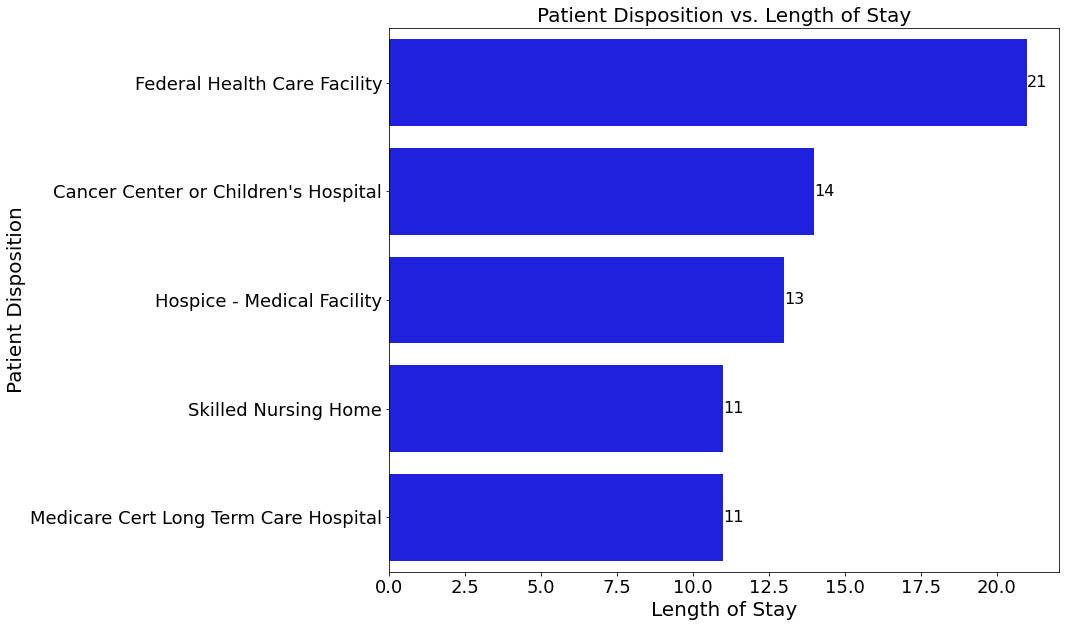

In [23]:
bar_graph(disposition['length_of_stay'],disposition['patient_disposition'], disposition,
          'Patient Disposition vs. Length of Stay', 'Length of Stay','Patient Disposition')

### Diagnosis vs. Length of Stay

In [24]:
diagnosis = patients.groupby(['ccs_diagnosis_description'])[['length_of_stay']].mean().sort_values(
                                                                    by='length_of_stay', ascending=False).head(5)

In [25]:
diagnosis.reset_index(inplace=True)

In [26]:
diagnosis['length_of_stay'] = diagnosis['length_of_stay'].apply(lambda x: int(x))

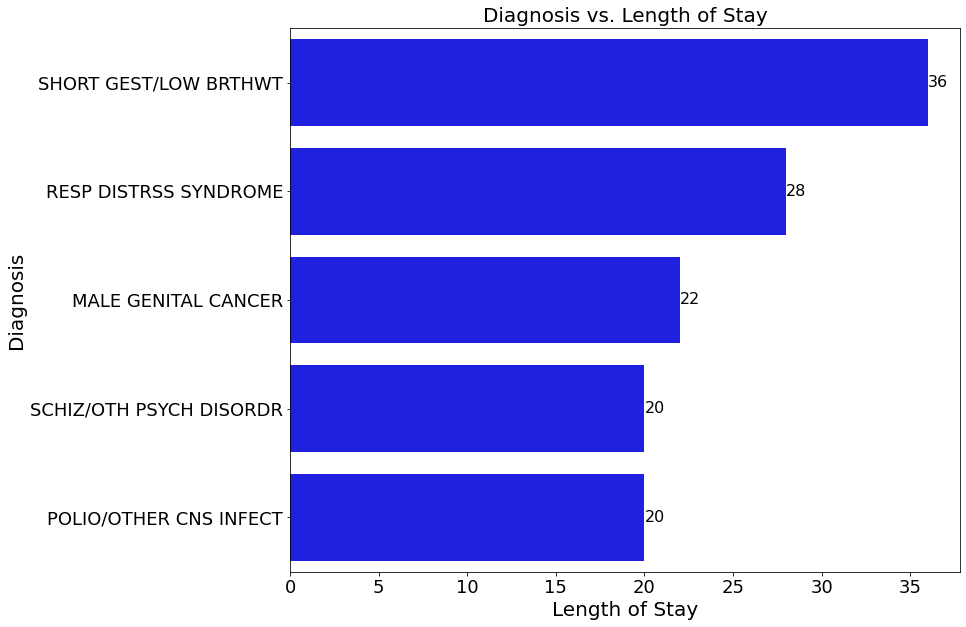

In [27]:
bar_graph(diagnosis['length_of_stay'],diagnosis['ccs_diagnosis_description'], diagnosis,
          'Diagnosis vs. Length of Stay', 'Length of Stay','Diagnosis')

### Procedure vs. Length of Stay

In [28]:
procedure = patients.groupby(['ccs_procedure_description'])[['length_of_stay']].mean().sort_values(
                                                                    by='length_of_stay', ascending=False).head(5)

In [29]:
procedure.reset_index(inplace=True)

In [30]:
procedure['length_of_stay'] = procedure['length_of_stay'].apply(lambda x: int(x))

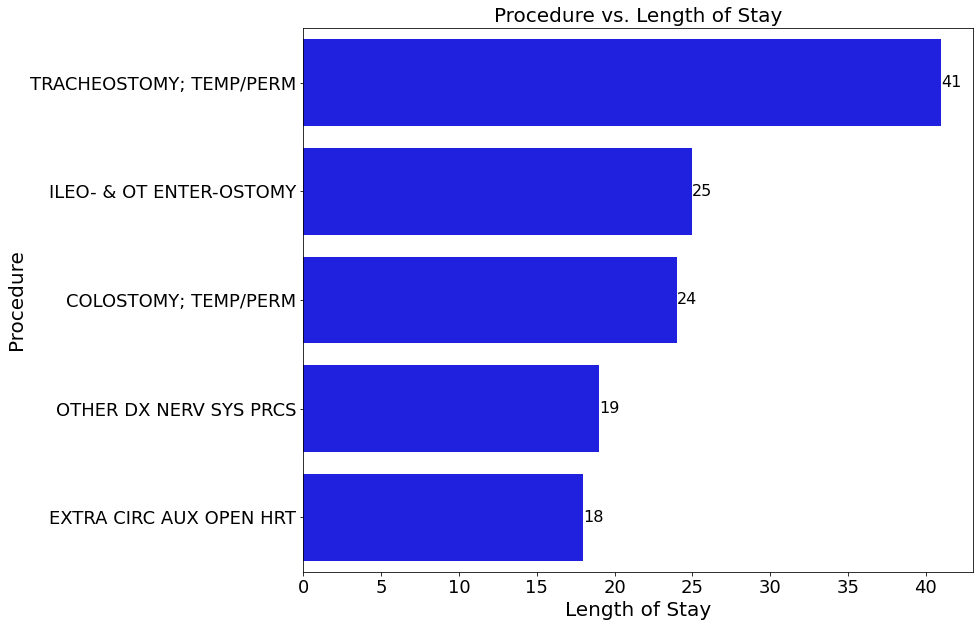

In [31]:
bar_graph(procedure['length_of_stay'],procedure['ccs_procedure_description'], procedure,
          'Procedure vs. Length of Stay', 'Length of Stay','Procedure')

## Model

### Train/Valid/Test Splits

In [32]:
X = patients.drop(columns = ['length_of_stay'], axis=1)
y = patients['length_of_stay']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, 
                                                      stratify=y_train)

In [35]:
#Showing that each dataset split possesses similar percentage of y values. 
print("Train percent:", y_train.value_counts(normalize=True)[1])
print("Valid percent: ", y_valid.value_counts(normalize=True)[1])
print("Hold percent: ", y_test.value_counts(normalize=True)[1])

Train percent: 0.14544578010207826
Valid percent:  0.14544425580079232
Hold percent:  0.14544905761620497


### Evaluation Metrics

In [36]:
#Creating a metrics function that will be reused for all of our modeling. It will contain the two metrics I am most
#focused on: recall and f1. 
def metrics_cv(cross_val_r2, cross_val_rmse, model_type, data):
    
    '''
    The function will take in two cross validation scores. One for recall and one for f1. It will then print out
    the mean score for the train and test sets from the cross validation folds. Additionally, it will take in the 
    model type used (logistic regression), and which dataset it is being performed on (train, valid).
    '''
    
    print(f"{model_type} {data} cross validation scores:")
    print('\n')
    print("r2 scores - ")
    print(f"Average Train Score: {np.mean(cross_val_r2['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_r2['test_score'])}")
    print('\n')
    print('rmse scores -')
    print(f"Average Train Score: {np.mean(cross_val_rmse['train_score'])}")
    print(f"Average Test Score: {np.mean(cross_val_rmse['test_score'])}")
    
#*4: Citation
#*5: Citation
#*6: Citation

### Categorical/Numerical Columns

In [37]:
def category(value):
    cols = []

    for col in patients.columns:
        if patients[col].dtype == value:
            cols.append(col)
        
    return cols

In [38]:
cat_cols = category('O')
num_cols = category('float64')

### Column Transformer for Preprocessing

In [39]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaled', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols)
    ])

### Baseline Linear Regression (No PCA)

In [40]:
baseline_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())
                             ])

In [41]:
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'])])),
                ('model', LinearRegression())])

In [42]:
baseline_r2 = cross_validate(baseline_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
baseline_rmse = cross_validate(baseline_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", 
                               return_train_score=True)

In [43]:
metrics_cv(baseline_r2,baseline_rmse, 'Baseline Linear Regression', 'X_train')

Baseline Linear Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.7475137371964214
Average Test Score: -180977439779729.84


rmse scores -
Average Train Score: -4.321365760923102
Average Test Score: -86293192.77328877


### Three Regression Models: Linear Regression, Decision Tree Regression, LinearSVR

#### Linear Regression with PCA

In [44]:
linreg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components= 200,random_state=42)),
                              ('model', LinearRegression())
                             ])

In [45]:
linreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'])])),
                ('pca', PCA(n_components=200, random_state=42)),
                ('model', LinearRegression())])

In [46]:
linreg_r2 = cross_validate(linreg_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
linreg_rmse = cross_validate(linreg_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", 
                             return_train_score=True)

In [47]:
metrics_cv(linreg_r2,linreg_rmse, 'Linear Regression', 'X_train')

Linear Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.7362132008915957
Average Test Score: 0.7344615996332126


rmse scores -
Average Train Score: -4.417073800672273
Average Test Score: -4.430522230828528


#### Decision Tree Regression

In [48]:
tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components= 300,random_state=42)),
                              ('model', DecisionTreeRegressor(random_state=42))
                             ])

In [49]:
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'])])),
                ('pca', PCA(n_components=300, random_state=42)),
                ('model', DecisionTreeRegressor(random_state=42))])

In [50]:
tree_r2 = cross_validate(tree_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
tree_rmse = cross_validate(tree_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", 
                           return_train_score=True)

In [51]:
metrics_cv(tree_r2, tree_rmse, 'Decision Tree Regression', 'X_train')

Decision Tree Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.993000438935335
Average Test Score: 0.838477663297611


rmse scores -
Average Train Score: -0.7154957288408398
Average Test Score: -3.4517655600528334


#### Linear SVR 

In [52]:
svr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components= 300)),
                              ('model', LinearSVR(random_state=0, tol=1e-5))
                             ])

In [53]:
svr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'])])),
                ('pca', PCA(n_components=300)),
                ('model', LinearSVR(random_state=0, tol=1e-05))])

In [54]:
svr_r2 = cross_validate(svr_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
svr_rmse = cross_validate(svr_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", 
                          return_train_score=True)

In [55]:
metrics_cv(svr_r2,svr_rmse, 'Linear SVR Regression', 'X_train')

Linear SVR Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.7032291284166808
Average Test Score: 0.7028874703886799


rmse scores -
Average Train Score: -4.685776176778594
Average Test Score: -4.684362102384223


### Tuning Linear SVR with Grid Search

In [56]:
param_space = {'model__loss':['squared_epsilon_insensitive'], #['epsilon_insensitive']
               'model__epsilon': [0.1], #[0.5, 1]
               'model__max_iter': [100], #[500,1000]
               'model__C': [0.1] #[1, 10]
               }

In [57]:
grid_search = GridSearchCV(svr_pipeline, param_space, scoring=['r2','neg_root_mean_squared_error'], 
                           refit='r2', cv=3)

In [58]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         ['total_charges',
                                                                          'total_costs']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['facility_name',
                                                                          'age_group',
                                                                          'gender',
                                                                          'race',
                                                                          'type_of_admission',
                                                                          'patient_disposition',
                                                                          'ccs_diagnosis_description',
                                                                          'ccs_procedure_description'])])),
                                       ('pca', PCA(n_components=300)),
                                       ('model',
                                        LinearSVR(random_state=0, tol=1e-05))]),
             param_grid={'model__C': [0.1], 'model__epsilon': [0.1],
                         'model__loss': ['squared_epsilon_insensitive'],
                         'model__max_iter': [100]},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'])

In [59]:
grid_search.best_params_

{'model__C': 0.1,
 'model__epsilon': 0.1,
 'model__loss': 'squared_epsilon_insensitive',
 'model__max_iter': 100}

In [60]:
tuned_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('pca', PCA(n_components= 300)),
                              ('model', LinearSVR(random_state=0, tol=1e-5, C=.1, epsilon=.1, 
                                                  loss='squared_epsilon_insensitive',max_iter=100))])

In [61]:
tuned_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  ['total_charges',
                                                   'total_costs']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['facility_name', 'age_group',
                                                   'gender', 'race',
                                                   'type_of_admission',
                                                   'patient_disposition',
                                                   'ccs_diagnosis_description',
                                                   'ccs_procedure_description'])])),
                ('pca', PCA(n_components=300)),
                ('model',
                 LinearSVR(C=0.1, epsilon=0.1,
                           loss='squared_epsilon_insensitive', max_iter=100,
                           random_state=0, tol=1e-05))])

In [62]:
tuned_r2 = cross_validate(tuned_pipeline, X_train, y_train, scoring="r2", return_train_score=True)
tuned_rmse = cross_validate(tuned_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", 
                            return_train_score=True)

tuned_v_r2 = cross_validate(tuned_pipeline, X_valid, y_valid, scoring="r2", return_train_score=True)
tuned_v_rmse = cross_validate(tuned_pipeline, X_valid, y_valid, scoring="neg_root_mean_squared_error", 
                            return_train_score=True)

In [63]:
metrics_cv(tuned_r2,tuned_rmse, 'Tuned LinearSVR Regression', 'X_train')
print('/n')
metrics_cv(tuned_v_r2,tuned_v_rmse, 'Tuned LinearSVR Regression', 'X_valid')

Tuned LinearSVR Regression X_train cross validation scores:


r2 scores - 
Average Train Score: 0.7185090921043514
Average Test Score: 0.7168082994042709


rmse scores -
Average Train Score: -4.563196124481495
Average Test Score: -4.573564845043153
/n
Tuned LinearSVR Regression X_valid cross validation scores:


r2 scores - 
Average Train Score: 0.5354686634429251
Average Test Score: 0.5247370341382387


rmse scores -
Average Train Score: -5.8238681588783
Average Test Score: -5.736906643105388


## Evaluation

### Final Model

**Final Model = LinearSVR(random_state=0, tol=1e-5, C=.1, epsilon=.1,loss='squared_epsilon_insensitive',max_iter=100)**

In [66]:
final_pipeline = linreg_pipeline


In [67]:
final_pipeline.score(X_test, y_test)

0.7439640302499733

In [68]:
y_pred = final_pipeline.predict(X_test)

In [69]:
rmse = sqrt(mean_squared_error(y_test, y_pred))

In [70]:
rmse

4.359668244643668

## Conclusion

### Limitations 

### Recommendations/Next Steps

#### Citations
- *1: https://www.kaggle.com/datasets/thedevastator/2010-new-york-state-hospital-inpatient-discharge
- *2: 
- *3: 
- *4: 
- *5: 
- *6: 
- *7: 
- *8: 
- *9: 